In [1]:
import matplotlib.pyplot as plt
import numpy as np
from brian2.only import *
import seaborn as sns
import deepdish as dd
import scipy.stats as stats

import plot_utils as pu
from digest import conds, get_voltages, get_voltage_histograms
import isi_indexing as ii
from readout import load_results

import conf.isi5_mouse as cfg
from demonstrator import demonstrator

import styling

In [2]:
K = 1.4
isi, STD, templ = 500, 1, 'R'
net, ipair, istim = [demonstrator[k] for k in ('net', 'ipair', 'istim')]
pair, stim, Bstim = cfg.pairings[ipair], cfg.pairings[ipair][istim], cfg.pairings[ipair][1-istim]

In [3]:
netf = dd.io.load(cfg.netfile.format(net=net))
X, Y = netf['X']/cfg.params['r_dish'].item(), netf['Y']/cfg.params['r_dish'].item()
W = netf['W']
Wb = W>0

In [4]:
TA = 0
res0 = load_results(cfg.fname.format(net=net, isi=isi, STD=STD, TA=TA, templ=templ))

episodes0 = {cond: res0['pairs'][ipair][cond][stim] for cond in conds}
sequences0 = {cond: res0['sequences'][episode] for cond, episode in episodes0.items()}
trials0 = {cond: seq == cfg.stimuli[stim] for cond, seq in sequences0.items()}
trials0.update({f'{cond}-nontarget': seq != cfg.stimuli[stim] for cond, seq in sequences0.items()})
trials0.update({f'{cond}-B': seq == cfg.stimuli[cfg.pairings[ipair][1-istim]] for cond, seq in sequences0.items()})

bspikes0 = {}
for cond in conds:
    bspikes0[cond] = np.zeros((cfg.params['N'], len(sequences0[cond]), res0['raw_dynamics']['v'].shape[-1]), bool)
    for itrial, (i, spike_t) in enumerate(zip(*[res0['raw_spikes'][episodes0[cond]][k] for k in ('pulsed_i', 'pulsed_t')])):
        t = (spike_t / cfg.params['dt'] + .5).astype(int)
        bspikes0[cond][i, itrial, t] = True
    assert np.all(bspikes0[cond].sum(2) == res0['raw_spikes'][episodes0[cond]]['pulsed_nspikes'].T)

In [5]:
XA0 = np.mean([bspikes0[cond][:, trials0[cond]].sum(2).mean(1) for cond in ('dev', 'msc')], 0)
xrA0 = {cond: 1-res0['raw_dynamics']['neuron_xr'][:, episodes0[cond], trials0[cond], 0].mean(1) for cond in ('dev', 'msc')}
DA0 = {cond: np.einsum('eo,e->o', Wb, XA0*xr) * K for cond, xr in xrA0.items()}
DA0['diff'] = DA0['dev'] - DA0['msc']

XB0 = np.mean([bspikes0[cond][:, trials0[f'{cond}-B']].sum(2).mean(1) for cond in ('dev', 'msc')], 0)
xrB0 = {cond: 1-res0['raw_dynamics']['neuron_xr'][:, episodes0[cond], trials0[f'{cond}-B'], 0].mean(1) for cond in ('dev', 'msc')}
DB0 = {cond: np.einsum('eo,e->o', Wb, XB0*xr) * K for cond, xr in xrB0.items()}
DB0['diff'] = DB0['dev'] - DB0['msc']

In [6]:
TA = 1
res = load_results(cfg.fname.format(net=net, isi=isi, STD=STD, TA=TA, templ=templ))

episodes = {cond: res['pairs'][ipair][cond][stim] for cond in conds}
sequences = {cond: res['sequences'][episode] for cond, episode in episodes.items()}
trials = {cond: seq == cfg.stimuli[stim] for cond, seq in sequences.items()}
trials.update({f'{cond}-nontarget': seq != cfg.stimuli[stim] for cond, seq in sequences.items()})
trials.update({f'{cond}-B': seq == cfg.stimuli[cfg.pairings[ipair][1-istim]] for cond, seq in sequences.items()})

bspikes = {}
for cond in conds:
    bspikes[cond] = np.zeros((cfg.params['N'], len(sequences[cond]), res['raw_dynamics']['v'].shape[-1]), bool)
    for itrial, (i, spike_t) in enumerate(zip(*[res['raw_spikes'][episodes[cond]][k] for k in ('pulsed_i', 'pulsed_t')])):
        t = (spike_t / cfg.params['dt'] + .5).astype(int)
        bspikes[cond][i, itrial, t] = True
    assert np.all(bspikes[cond].sum(2) == res['raw_spikes'][episodes[cond]]['pulsed_nspikes'].T)

In [7]:
XA = np.mean([bspikes[cond][:, trials[cond]].sum(2).mean(1) for cond in ('dev', 'msc')], 0)
xrA = {cond: 1-res['raw_dynamics']['neuron_xr'][:, episodes[cond], trials[cond], 0].mean(1) for cond in ('dev', 'msc')}
DA = {cond: np.einsum('eo,e->o', Wb, XA*xr) * K for cond, xr in xrA.items()}
DA['diff'] = DA['dev'] - DA['msc']

XB = np.mean([bspikes[cond][:, trials[f'{cond}-B']].sum(2).mean(1) for cond in ('dev', 'msc')], 0)
xrB = {cond: 1-res['raw_dynamics']['neuron_xr'][:, episodes[cond], trials[f'{cond}-B'], 0].mean(1) for cond in ('dev', 'msc')}
DB = {cond: np.einsum('eo,e->o', Wb, XB*xr) * K for cond, xr in xrB.items()}
DB['diff'] = DB['dev'] - DB['msc']

In [8]:
def scatter_values(ax, **kwargs):
    m = ax.scatter(X, Y, **kwargs)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlim(-1.1,1.1)
    ax.set_ylim(-1.1,1.1)
    ax.set_aspect('equal')
    sns.despine(ax=ax, left=True, bottom=True)
    return m

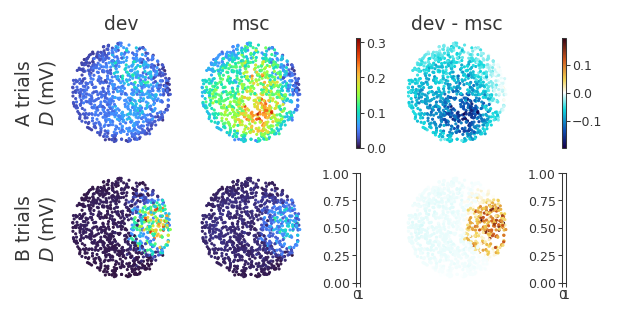

In [9]:
def panel_D(axs_raw, axs_contrast, cax_raw, cax_contrast, DA, DB, ms=1):
    vmax = np.abs([DA['dev'], DA['msc'], DB['dev'], DB['msc']]).max()
    m = scatter_values(axs_raw[0, 0], c=DA['dev'], s=ms, vmin=0, vmax=vmax, cmap='turbo')
    m = scatter_values(axs_raw[0, 1], c=DA['msc'], s=ms, vmin=0, vmax=vmax, cmap='turbo')
    m = scatter_values(axs_raw[1, 0], c=DB['dev'], s=ms, vmin=0, vmax=vmax, cmap='turbo')
    m = scatter_values(axs_raw[1, 1], c=DB['msc'], s=ms, vmin=0, vmax=vmax, cmap='turbo')
    plt.colorbar(m, cax=cax_raw)

    vmax = np.abs([DA['diff'], DB['diff']]).max()
    m = scatter_values(axs_contrast[0], c=DA['diff'], s=ms, vmin=-vmax, vmax=vmax, cmap=pu.ccc_divergent)
    m = scatter_values(axs_contrast[1], c=DB['diff'], s=ms, vmin=-vmax, vmax=vmax, cmap=pu.ccc_divergent)
    plt.colorbar(m, cax=cax_contrast)

    for ax, cond in zip([*axs_raw[0], axs_contrast[0]], ('dev', 'msc', 'dev - msc')):
        ax.set_title(cond)
    for ax, AB in zip(axs_raw[:, 0], 'AB'):
        ax.set_ylabel(f'{AB} trials\n$D$ (mV)', fontsize=plt.rcParams['axes.titlesize'])
fig, axs = plt.subplots(2, 5, figsize=(4, 2), constrained_layout=True, width_ratios=pu.fill_ratios(-1,-1,1,-1,1), dpi=150)
panel_D(axs[:, :2], axs[:, 3], axs[0,2], axs[0,4], DA, DB)

In [10]:
Ddata = dd.io.load('Fig8-synergy.h5', '/D')
Ddata_TA0 = dd.io.load('Fig8-synergy.TA0.h5', '/D')

dev D^A < D^B: t = -2.57, p = 0.00577
msc D^A < D^B: t = 2.34, p = 0.989
dD^A < 0: t = -7.72, p = 1.99e-12
dD^B > 0: t = 9.66, p = 6e-17
-dD^A < dD^B: t = 1.46, p = 0.926


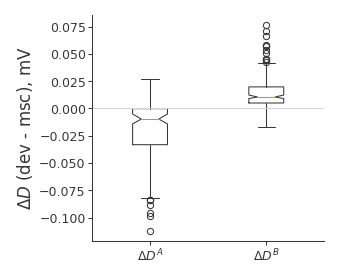

In [11]:
def panel_stats_diff(ax, Ddata):
    DA = {cond: np.asarray([Ddata[k]['A'][cond] for k in range(len(Ddata))]) for cond in ('dev', 'msc')}
    DB = {cond: np.asarray([Ddata[k]['B'][cond] for k in range(len(Ddata))]) for cond in ('dev', 'msc')}
    dD = {'A': DA['dev'] - DA['msc'], 'B': DB['dev'] - DB['msc']}

    mean_dD = {AB: np.mean(dD[AB], 1) for AB in 'AB'}

    ax.boxplot(
        [mean_dD['A'], mean_dD['B']], notch=True, bootstrap=10000,
        labels=['$\\Delta D^A$', '$\\Delta D^B$'], widths=.3)
    ax.axhline(0, color='lightgrey')
    ax.set_ylabel('$\\Delta D$ (dev - msc), mV')
    sns.despine(ax=ax)

    test = stats.ttest_rel(np.mean(DA['dev'], 1), np.mean(DB['dev'], 1), alternative='less')
    print(f'dev D^A < D^B: t = {test.statistic:.3g}, p = {test.pvalue:.3g}')
    test = stats.ttest_rel(np.mean(DA['msc'], 1), np.mean(DB['msc'], 1), alternative='less')
    print(f'msc D^A < D^B: t = {test.statistic:.3g}, p = {test.pvalue:.3g}')

    test = stats.ttest_1samp(mean_dD['A'], 0, alternative='less')
    print(f'dD^A < 0: t = {test.statistic:.3g}, p = {test.pvalue:.3g}')

    test = stats.ttest_1samp(mean_dD['B'], 0, alternative='greater')
    print(f'dD^B > 0: t = {test.statistic:.3g}, p = {test.pvalue:.3g}')

    test = stats.ttest_rel(-mean_dD['A'], mean_dD['B'], alternative='less')
    print(f'-dD^A < dD^B: t = {test.statistic:.3g}, p = {test.pvalue:.3g}')

fig, ax = plt.subplots(figsize=(2,2), dpi=150)
panel_stats_diff(ax, Ddata[1])

With TA:
dev D^A < D^B: t = -2.57, p = 0.00577
msc D^A < D^B: t = 2.34, p = 0.989
dD^A < 0: t = -7.72, p = 1.99e-12
dD^B > 0: t = 9.66, p = 6e-17
-dD^A < dD^B: t = 1.46, p = 0.926

Without TA:
dev D^A < D^B: t = -5.93, p = 1.54e-08
msc D^A < D^B: t = 0.245, p = 0.596
dD^A < 0: t = -2.2, p = 0.0148
dD^B > 0: t = 12, p = 1.6e-22
-dD^A < dD^B: t = -2.89, p = 0.00226


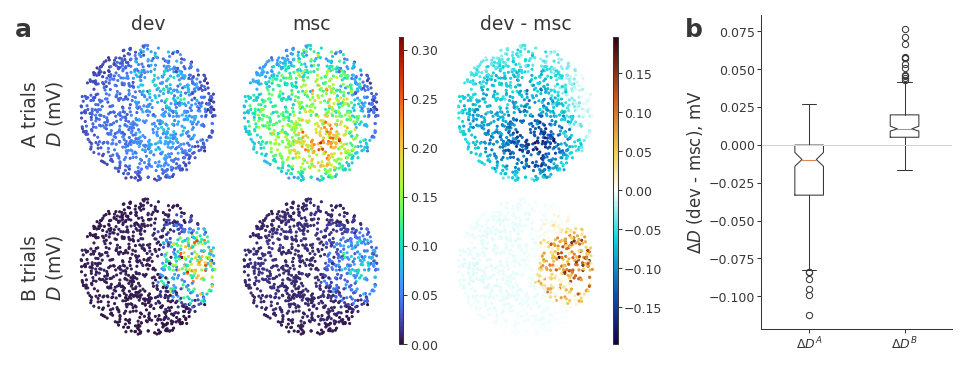

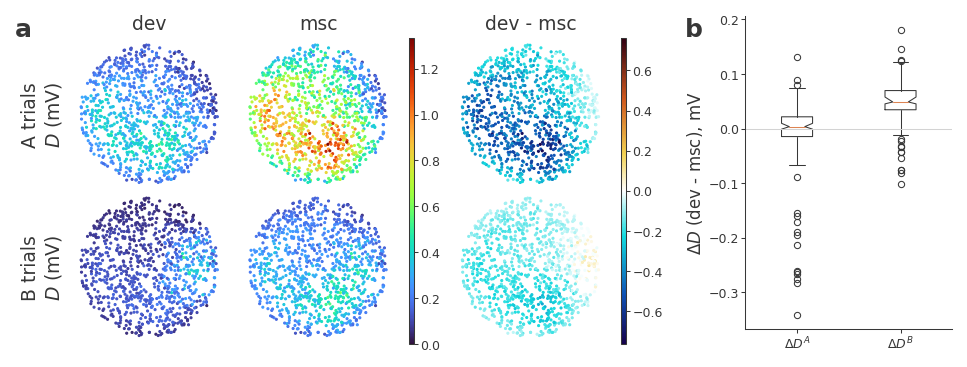

In [12]:
def make_fig8(DA, DB, Ddata):
    fig = plt.figure(figsize=(6.29, 2.25), layout='compressed', dpi=150)
    gs_top = fig.add_gridspec(1, 2, width_ratios=(7,3))

    subfig_left = fig.add_subfigure(gs_top[0])
    wr = pu.fill_ratios(-1, -1, 1, -1, 1)
    gs_left = subfig_left.add_gridspec(2, 5, width_ratios=wr, hspace=0)
    cax_raw = subfig_left.add_subplot(gs_left[:, 2])
    cax_contrast = subfig_left.add_subplot(gs_left[:, -1])
    axs_raw = np.asarray([[subfig_left.add_subplot(gs_left[row, col]) for col in range(2)] for row in range(2)])
    axs_contrast = [subfig_left.add_subplot(gs_left[row, 3]) for row in range(2)]
    panel_D(axs_raw, axs_contrast, cax_raw, cax_contrast, DA, DB)
    subfig_left.get_layout_engine().set(h_pad=0, hspace=0.1)

    subfig_right = fig.add_subfigure(gs_top[1])
    ax = subfig_right.add_subplot()
    panel_stats_diff(ax, Ddata)

    fig.text(0, .99, 'a', **styling.label_kwargs, ha='left', va='top')
    fig.text(.71, .99, 'b', **styling.label_kwargs, ha='left', va='top')

print('With TA:')
make_fig8(DA, DB, Ddata[1])
plt.savefig('paper-1/fig8.pdf')

print('\nWithout TA:')
make_fig8(DA0, DB0, Ddata_TA0[1])
plt.savefig('paper-1/fig8-noTA.pdf')

In [13]:
spikes = res['spikes'][ipair][stim]['dev']['nspikes'].mean(0)
stimid = res['stimuli'][stim]
r, p = [], []
for dtrial in range(1,4):
    shifted = np.roll(sequences['dev'], dtrial)
    shifted[:dtrial] = -1
    x = res['raw_dynamics']['neuron_xr'][:, episodes['dev'], shifted==stimid, 0].mean(1)
    correlation = stats.pearsonr(spikes[:cfg.params['N_exc']], x[:cfg.params['N_exc']])
    r.append(correlation[0])
    p.append(correlation[1])
    print(f'Lag {dtrial}: r = {r[-1]:.3g}, p = {p[-1]:.3g}')

Lag 1: r = -0.984, p = 0
Lag 2: r = -0.0525, p = 0.138
Lag 3: r = -0.142, p = 5.71e-05
